<a href="https://colab.research.google.com/github/Noob-Coder2/Network-Traffic-Prediction/blob/main/Centralized_XGBoost_Benchmark_(No_Chat_%2B_Quantile_Transform).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installation

Install XGBoost and other necessary libraries.

In [ ]:
!pip install -q xgboost scikit-learn pandas matplotlib seaborn
print("Installing Libraries")

Installing Libraries


### Imports

Import all necessary libraries for the project.

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, QuantileTransformer, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

print("Libraries imported successfully.")


Libraries imported successfully.


### Data Loading and Advanced Preprocessing

This cell implements the new preprocessing pipeline: removing the 'CHAT' class and using Quantile Transformation.

In [ ]:
from google.colab import drive
# drive.mount('/content/drive')
DRIVE_PATH = '/content/drive/MyDrive/Network Application Prediction/'
DATASET_PATH = os.path.join(DRIVE_PATH, 'consolidated_NonVPN.csv')

try:
    df = pd.read_csv(DATASET_PATH)
    print(f"Dataset loaded successfully from '{DATASET_PATH}'.")
except FileNotFoundError:
    print(f"Error: Dataset not found at '{DATASET_PATH}'. Please check the path.")
    df = pd.DataFrame()

if not df.empty:
    # Remove the noisy 'CHAT' class
    df = df[df['traffic_type'] != 'CHAT'].copy()

    # Initial Feature Engineering
    epsilon = 1e-6
    df['avg_packet_size'] = df['flowBytesPerSecond'] / (df['flowPktsPerSecond'] + epsilon)
    df['active_idle_ratio'] = df['mean_active'] / (df['mean_idle'] + epsilon)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    # Label Encoding
    label_encoder = LabelEncoder()
    df['traffic_type_encoded'] = label_encoder.fit_transform(df['traffic_type'])
    num_classes = len(label_encoder.classes_)

    # Separate features and target
    X_features = df.drop(columns=['traffic_type', 'traffic_type_encoded'])
    y = df['traffic_type_encoded']

    # Quantile Transformation
    qt = QuantileTransformer(output_distribution='normal', n_quantiles=min(1000, len(X_features)-1))
    X_transformed = pd.DataFrame(qt.fit_transform(X_features), columns=X_features.columns)

    # --- ADVANCED FEATURE ENGINEERING ---
    # 1. Select the top 15 most important base features
    print("\nSelecting the most important base features...")
    selector = SelectFromModel(
        RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1),
        max_features=15, threshold=-np.inf
    )
    y.reset_index(drop=True, inplace=True)
    X_transformed.reset_index(drop=True, inplace=True)
    X_top_features = selector.fit_transform(X_transformed, y)
    top_feature_names = X_transformed.columns[selector.get_support()]
    X_top_df = pd.DataFrame(X_top_features, columns=top_feature_names)
    print(f"Selected {len(top_feature_names)} base features.")

    # 2. Create interaction features ONLY from this top subset
    print("Creating interaction features from the top subset...")
    poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
    poly_features = poly.fit_transform(X_top_df)
    X_final = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(top_feature_names))
    print(f"Created a final set of {X_final.shape[1]} powerful features.")

    # Data Splitting and Scaling
    X_train, X_test, y_train, y_test = train_test_split(
        X_final, y, test_size=0.2, random_state=42, stratify=y
    )
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_final.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_final.columns)
    print("\nPreprocessing complete.")


Dataset loaded successfully from '/content/drive/MyDrive/Network Application Prediction/consolidated_NonVPN.csv'.

Selecting the most important base features...
Selected 15 base features.
Creating interaction features from the top subset...
Created a final set of 120 powerful features.

Preprocessing complete.


### Feature Importance Analysis

This cell analyzes and displays the importance of our newly engineered features.


--- Analyzing Importance of Engineered Features ---
Top 30 most important features:
                                feature  importance  importance_pct
14                      avg_packet_size    0.065523        6.552268
11                          max_flowiat    0.036695        3.669539
13                          std_flowiat    0.034397        3.439736
12                         mean_flowiat    0.019195        1.919497
10                          min_flowiat    0.018913        1.891270
50               total_biat max_flowiat    0.018403        1.840251
32                  total_fiat max_fiat    0.018101        1.810111
52               total_biat std_flowiat    0.017113        1.711327
54                    min_fiat min_biat    0.016619        1.661888
91            mean_fiat avg_packet_size    0.016617        1.661730
6                             mean_fiat    0.015918        1.591796
0                              duration    0.015887        1.588675
98            mean_biat avg_pac

/tmp/ipython-input-3904145541.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance_pct', y='feature', data=importances.head(20), palette='viridis')


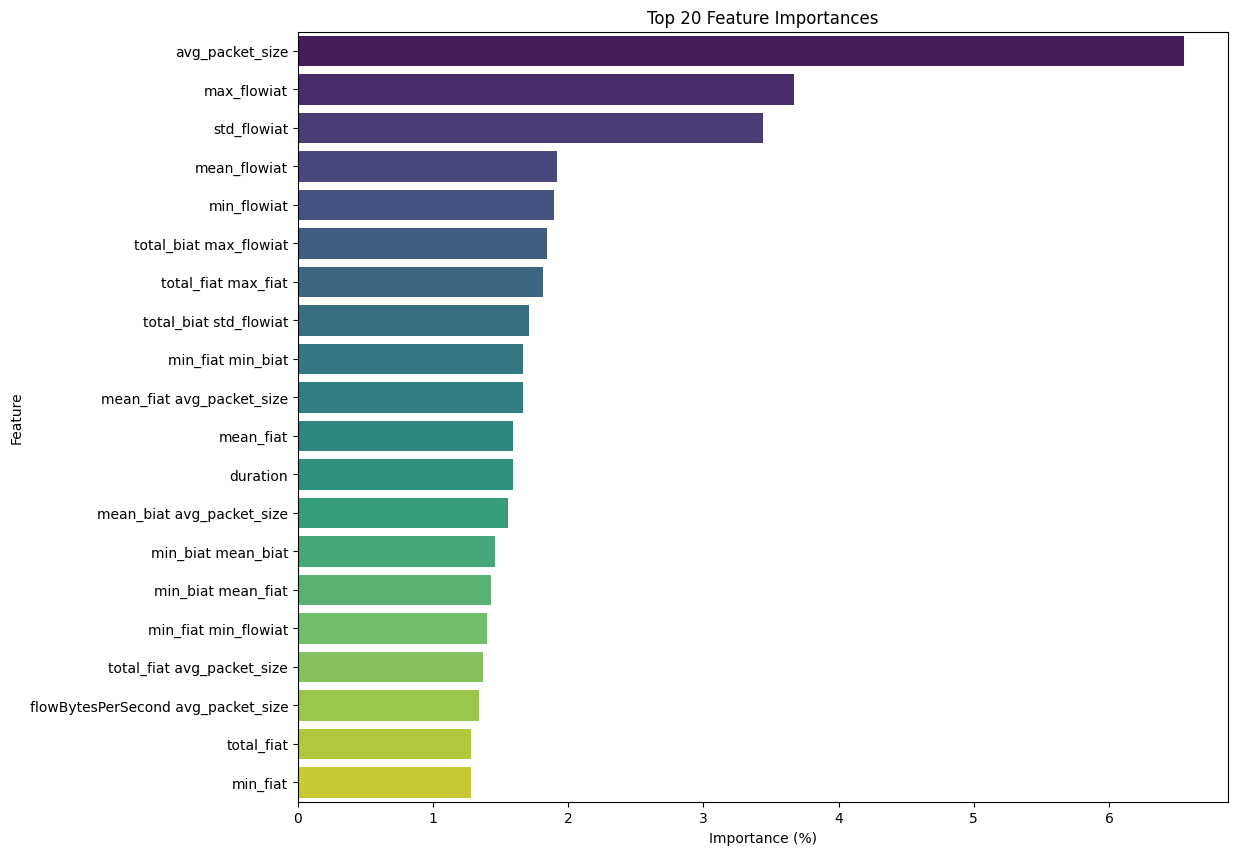

In [ ]:

if not df.empty:
    print("\n--- Analyzing Importance of Engineered Features ---")

    # Train a RandomForest on the new feature set to get importance scores
    rfc_importances = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rfc_importances.fit(X_train, y_train)

    # Create a dataframe of feature importances
    importances = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rfc_importances.feature_importances_
    })

    # Sort by importance and calculate percentage
    importances = importances.sort_values('importance', ascending=False)
    importances['importance_pct'] = (importances['importance'] / importances['importance'].sum()) * 100

    print("Top 30 most important features:")
    print(importances.head(30).to_string())

    # Plot the top 20 features
    plt.figure(figsize=(12, 10))
    sns.barplot(x='importance_pct', y='feature', data=importances.head(20), palette='viridis')
    plt.title('Top 20 Feature Importances')
    plt.xlabel('Importance (%)')
    plt.ylabel('Feature')
    plt.show()


### Define the Optuna Objective Function

This function defines one "trial". Optuna will call this function many times with different hyperparameter combinations to find the best one.

In [ ]:
# def objective(trial):
#     """Defines the search space and trains a model for one trial."""
#     param = {
#         'objective': 'multi:softmax',
#         'num_class': num_classes,
#         'eval_metric': 'mlogloss',
#         'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'subsample': trial.suggest_float('subsample', 0.6, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
#         'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
#         'random_state': 42,
#         'n_jobs': -1
#     }
#     X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
#     model = xgb.XGBClassifier(**param)
#     model.fit(X_train_part, y_train_part,
#               eval_set=[(X_val, y_val)],
#               verbose=False)
#     preds = model.predict(X_val)
#     accuracy = accuracy_score(y_val, preds)
#     return accuracy

### Train the XGBoost Model

This cell trains the centralized XGBoost model on the new, cleaner feature set.



--- Training Final Model with Optimal Hyperparameters ---

--- Evaluating Final Tuned Model ---

Final Tuned XGBoost Accuracy with Advanced Features: 0.9801

Classification Report:
              precision    recall  f1-score   support

    BROWSING       0.98      1.00      0.99      2000
          FT       0.93      0.98      0.95       795
        MAIL       0.98      0.91      0.94       273
         P2P       1.00      0.99      0.99       800
   STREAMING       0.98      0.86      0.92       257
        VOIP       1.00      0.99      0.99      1297

    accuracy                           0.98      5422
   macro avg       0.98      0.95      0.96      5422
weighted avg       0.98      0.98      0.98      5422



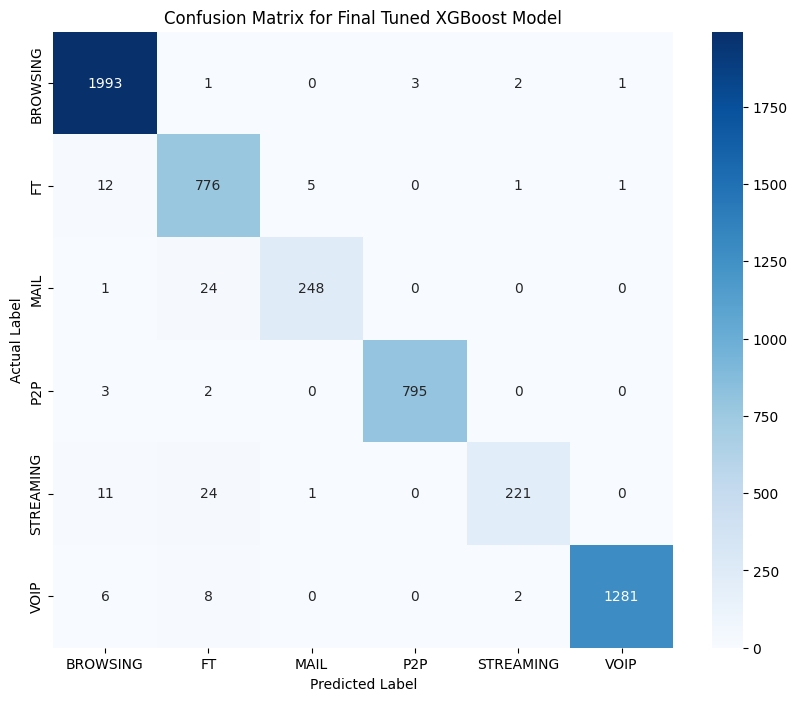

In [ ]:

if not df.empty:
    print("\n--- Training Final Model with Optimal Hyperparameters ---")

    # The best hyperparameters discovered from the previous Optuna run
    best_params = {
        'n_estimators': 433,
        'learning_rate': 0.05707504177265415,
        'max_depth': 10,
        'subsample': 0.8646209304564666,
        'colsample_bytree': 0.76575838671692,
        'gamma': 0.006522223636191973
    }

    # Add the fixed parameters
    final_params = {
        'objective': 'multi:softmax',
        'num_class': num_classes,
        'eval_metric': 'mlogloss',
        'random_state': 42,
        'n_jobs': -1,
        **best_params # Unpack the best parameters here
    }

    final_model = xgb.XGBClassifier(**final_params)
    final_model.fit(X_train, y_train)

    print("\n--- Evaluating Final Tuned Model ---")
    y_pred = final_model.predict(X_test)
    final_accuracy = accuracy_score(y_test, y_pred)

    print(f"\nFinal Tuned XGBoost Accuracy with Advanced Features: {final_accuracy:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix for Final Tuned XGBoost Model')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()


### Run the Hyperparameter Optimization Study

This cell launches the Optuna study to find the best parameters.

In [ ]:

# if not df.empty:
#     print("\n--- Starting Hyperparameter Optimization with Optuna ---")
#     # Create a study object and specify the direction as "maximize"
#     study = optuna.create_study(direction='maximize')

#     # Start the optimization. Optuna will run 100 trials.
#     study.optimize(objective, n_trials=100)

#     print("\nOptimization finished.")
#     print("Number of finished trials: ", len(study.trials))
#     print("Best trial:")
#     best_trial = study.best_trial

#     print("  Value: ", best_trial.value)
#     print("  Params: ")
#     for key, value in best_trial.params.items():
#         print(f"    {key}: {value}")

#     # Store the best hyperparameters
#     best_params = best_trial.params


### Evaluate the New Benchmark Model

This cell evaluates the model's performance to establish our new, higher benchmark.

In [ ]:
# if not df.empty:
#     print("\n--- Evaluating New Benchmark Model Performance ---")

#     # 1. Make predictions on the test set
#     y_pred = xgb_model.predict(X_test)

#     # 2. Calculate and print accuracy
#     accuracy = accuracy_score(y_test, y_pred)
#     print(f"\nNew Centralized XGBoost Benchmark Accuracy: {accuracy:.4f}")

#     # 3. Print a detailed classification report
#     print("\nClassification Report:")
#     print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

#     # 4. Visualize the Confusion Matrix
#     cm = confusion_matrix(y_test, y_pred)
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#                 xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
#     plt.title('Confusion Matrix for New Centralized XGBoost Benchmark')
#     plt.ylabel('Actual Label')
#     plt.xlabel('Predicted Label')
#     plt.show()

### Train and Evaluate the Final, Tuned Model

Now we train one final model using the best parameters found by Optuna.


In [ ]:

# if not df.empty:
#     print("\n--- Training Final Model with Optimal Hyperparameters ---")

#     # Add the fixed parameters to the best ones found by Optuna
#     final_params = {
#         'objective': 'multi:softmax',
#         'num_class': num_classes,
#         'eval_metric': 'mlogloss',
#         'random_state': 42,
#         'n_jobs': -1,
#         **best_params # Unpack the best parameters here
#     }

#     final_model = xgb.XGBClassifier(**final_params)
#     final_model.fit(X_train, y_train)

#     print("\n--- Evaluating Final Tuned Model ---")
#     y_pred = final_model.predict(X_test)
#     final_accuracy = accuracy_score(y_test, y_pred)

#     print(f"\nFinal Tuned XGBoost Accuracy: {final_accuracy:.4f}")

#     print("\nClassification Report:")
#     print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

#     cm = confusion_matrix(y_test, y_pred)
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#                 xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
#     plt.title('Confusion Matrix for Final Tuned XGBoost Model')
#     plt.ylabel('Actual Label')
#     plt.xlabel('Predicted Label')
#     plt.show()
